In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm

In [2]:
!unzip ./drive/MyDrive/classify-leaves.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: images/5500.jpg         
  inflating: images/5501.jpg         
  inflating: images/5502.jpg         
  inflating: images/5503.jpg         
  inflating: images/5504.jpg         
  inflating: images/5505.jpg         
  inflating: images/5506.jpg         
  inflating: images/5507.jpg         
  inflating: images/5508.jpg         
  inflating: images/5509.jpg         
  inflating: images/551.jpg          
  inflating: images/5510.jpg         
  inflating: images/5511.jpg         
  inflating: images/5512.jpg         
  inflating: images/5513.jpg         
  inflating: images/5514.jpg         
  inflating: images/5515.jpg         
  inflating: images/5516.jpg         
  inflating: images/5517.jpg         
  inflating: images/5518.jpg         
  inflating: images/5519.jpg         
  inflating: images/552.jpg          
  inflating: images/5520.jpg         
  inflating: images/5521.jpg         
  inflating: images/5522.jpg         
  inflating: images/552

In [3]:
!ls


drive  images  sample_data  sample_submission.csv  test.csv  train.csv


In [4]:
# 看看label文件长啥样
labels_dataframe = pd.read_csv('./train.csv')
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}

176


In [28]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path)  
        self.data_info = self.data_info.sample(frac=1).reset_index(drop=True)
        # 计算 length
        self.data_len = len(self.data_info.index)
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[0:self.train_len-1, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[0:self.train_len-1, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len
train_path = './train.csv'
test_path = './test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = './'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3671 samples found)
Finished reading the test set of Leaves Dataset (8799 samples found)


In [29]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=12, 
        shuffle=False,
        num_workers=2
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=12, 
        shuffle=False,
        num_workers=2
    )

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=12, 
        shuffle=False,
        num_workers=2
    )

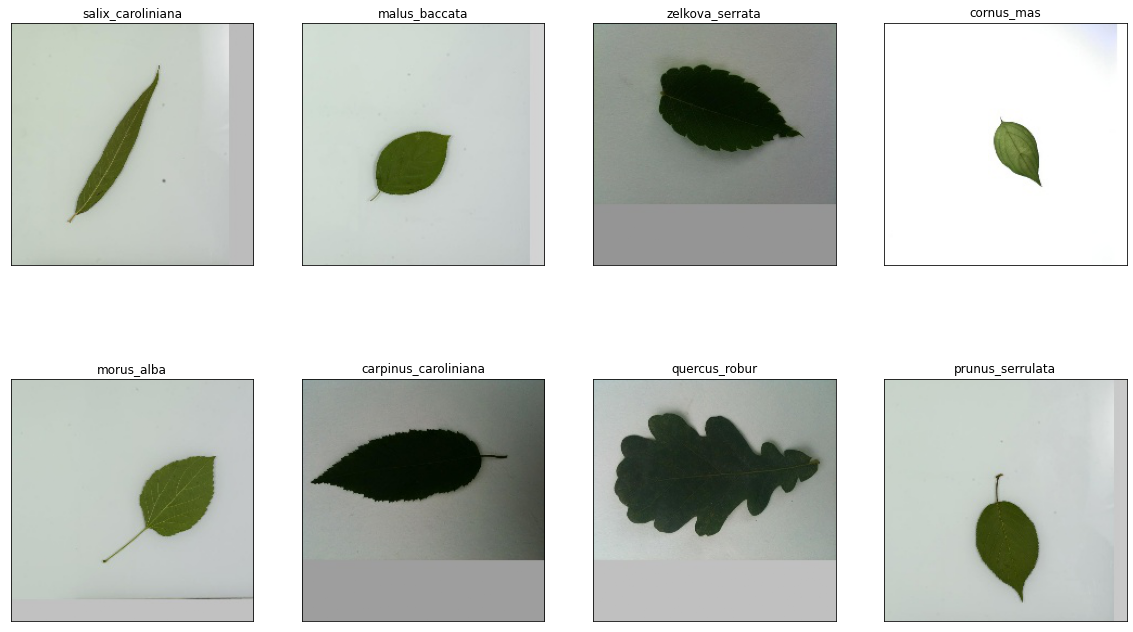

In [7]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [8]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import color,img_as_float
#这是原版的
class Block(nn.Module):
    growth = 2

    def __init__(self, inputs, cardinality=32, block_width=4, stride=1):
        super(Block, self).__init__()
        outs = cardinality*block_width
        self.left = nn.Sequential(
            nn.Conv2d(inputs, outs, kernel_size=1, bias=False),
            nn.BatchNorm2d(outs),
            nn.ReLU(),
            nn.Conv2d(outs, outs, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False),
            nn.BatchNorm2d(outs),
            nn.ReLU(),
            nn.Conv2d(outs, self.growth * outs, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.growth * outs)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or inputs != self.growth * outs:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inputs, self.growth * outs, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.growth * outs)
            )

    def forward(self, inputs):
        network = self.left(inputs)
        network += self.shortcut(inputs)
        out = F.relu(network)
        return out


class ResnextNet(nn.Module):
    def __init__(self, layers, cardinality, block_width):
        super(ResnextNet, self).__init__()
        self.inputs = 64
        self.cardinality = cardinality
        self.block_width = block_width

        self.pad2d = nn.ReplicationPad2d((0,1,0,1))
        self.MaxPool2d = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)         
       
        self.wconv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, padding=0, stride=1, bias=False)
        self.wconv2 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1, bias=False)
               
        self.wbn64 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU()              
        self.conv2 = self._block(layers=layers[0], stride=1)
        self.conv3 = self._block(layers=layers[1], stride=2)
        self.conv4 = self._block(layers=layers[2], stride=2)
        self.conv5 = self._block(layers=layers[3], stride=2)

        self.linear = nn.Linear(8 * cardinality * block_width, 40)

    def forward(self, inputs):
        t1 = self.wconv1(inputs)
        t1 = self.MaxPool2d(self.pad2d(t1))
        t2 = self.MaxPool2d(self.wconv2(inputs))    
        
        network = torch.cat((t1,t2),1)
        network = self.relu(self.wbn64(network))
        network = self.conv2(network)
        network = self.conv3(network)
        network = self.conv4(network)
        network = self.conv5(network)
        network = nn.BatchNorm2d(network.shape[1])(network)
        network = nn.Conv2d(in_channels=network.shape[1],out_channels=176,kernel_size=1)(network)
        print(network.shape)
        network = F.avg_pool2d(network,network.shape[2]) 
        network = network.view(network.size(0), -1)
        print(network.shape)
        return network 

       

    def _block(self, layers, stride):
        strides = [stride] + [1] * (layers - 1)  # strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(Block(self.inputs, self.cardinality, self.block_width, stride))
            self.inputs = self.block_width*self.cardinality*Block.growth
        return nn.Sequential(*layers)


def ResNext50_32x4d():
    return ResnextNet(layers=[3, 4, 6, 3], cardinality=32, block_width=4)


def ResNext50_4x32d():
    return ResnextNet(layers=[3, 4, 6, 3], cardinality=4, block_width=32)


def ResNext50_64x4d():
    return ResnextNet(layers=[3, 4, 6, 3], cardinality=64, block_width=4)


def ResNext101_32x4d():
    return ResnextNet(layers=[3, 4, 23, 3], cardinality=32, block_width=4)


def ResNext101_64x4d():
    return ResnextNet(layers=[3, 4, 23, 3], cardinality=64, block_width=4)


In [9]:
# x = torch.rand((4,3,224,224))
# model =  ResNext50_32x4d()
# y = model(x)
import torch
y = torch.tensor([1,2,3,1])
labels = torch.tensor([1,2,3,4])
(y==labels).float().sum()

tensor(3.)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNext50_32x4d()
# model.load_state_dict(torch.load("/content/pre_res_model.ckpt"))
model = model.to(device)
model.device = device

n_epochs = 100
lr_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0)


best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    model.train() 
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)

        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(logits.shape)
        print(labels.shape)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    scheduler.step()
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    model.eval()
    valid_loss = []
    valid_accs = []
    
    for batch in tqdm(val_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

In [22]:
saveFileName = './submission.csv'

In [25]:
## predict
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load("/content/pre_res_model.ckpt"))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")






  0%|          | 0/8799 [00:00<?, ?it/s]




  0%|          | 2/8799 [00:00<08:01, 18.25it/s]




  0%|          | 12/8799 [00:00<06:04, 24.14it/s]




  0%|          | 23/8799 [00:00<04:40, 31.33it/s]




  0%|          | 36/8799 [00:00<03:37, 40.30it/s]




  1%|          | 49/8799 [00:00<02:52, 50.76it/s]




  1%|          | 63/8799 [00:00<02:19, 62.47it/s]




  1%|          | 77/8799 [00:00<01:57, 74.27it/s]




  1%|          | 92/8799 [00:00<01:40, 86.58it/s]




  1%|          | 107/8799 [00:00<01:28, 98.41it/s]




  1%|▏         | 122/8799 [00:01<01:20, 107.68it/s]




  2%|▏         | 136/8799 [00:01<01:16, 113.01it/s]




  2%|▏         | 150/8799 [00:01<01:12, 119.44it/s]




  2%|▏         | 165/8799 [00:01<01:08, 125.48it/s]




  2%|▏         | 179/8799 [00:01<01:06, 128.78it/s]




  2%|▏         | 194/8799 [00:01<01:04, 133.16it/s]




  2%|▏         | 208/8799 [00:01<01:04, 134.13it/s]




  3%|▎         | 223/8799 [00:01<01:02, 137.44it/s]




  3%|▎         |

Done!!!!!!!!!!!!!!!!!!!!!!!!!!!
